In [1]:
import re
import numpy as np
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ALLCools.plot import *
from matplotlib import patches
from matplotlib.cm import get_cmap
from adjustText import adjust_text
from matplotlib.colors import ListedColormap, Normalize

In [2]:
from matplotlib import rc
labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth - 0.2)
rc('ytick.minor', width=linewidth - 0.2)

## Gene metadata

In [3]:
motif_gene_anno = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/MotifClustering/JASPAR2020_CORE_vertebrates_non-redundant.mouse_genes.with_motif_group.199.csv', 
    index_col=0
)
tf_class = pd.read_csv('/home/hanliu/ref/TFGene/TFClass/TFClass.with_mouse_gene_id.csv')
for tf_col in ['Class', 'Family', 'SubFamily']:
    gene_class_map = {}
    for _, (class_name, genes) in tf_class[[tf_col, 'EnsemblID']].iterrows():
        if isinstance(genes, float):
            continue
        for gene in genes.split(','):
            gene_class_map[gene] = class_name
    
    motif_gene_anno[tf_col] = motif_gene_anno['gene_ids'].apply(lambda i: gene_class_map.get(i.split('.')[0], ''))

motif_gene_anno['SubFamily'] = motif_gene_anno['SubFamily'].replace('', np.nan).fillna('unclassified')
motif_gene_anno.head()

,motif_name,motif_genes,gene_ids,gene_names,motif_group,Class,Family,SubFamily
motif_uid,,,,,,,,
MA0006.1,Ahr::Arnt,"Ahr,Arnt","ENSMUSG00000019256.17,ENSMUSG00000015522.18","Ahr,Arnt",MotifGroup178,Basic helix-loop-helix factors (bHLH),PAS,PAS-AHR
MA0854.1,Alx1,Alx1,ENSMUSG00000036602.14,Alx1,MotifGroup3,Homeo domain factors,Paired-related HD,ALX
MA0634.1,ALX3,ALX3,ENSMUSG00000014603.3,Alx3,MotifGroup3,Homeo domain factors,Paired-related HD,TPRX
MA0853.1,Alx4,Alx4,ENSMUSG00000040310.12,Alx4,MotifGroup3,Homeo domain factors,Paired-related HD,ALX
MA0007.3,Ar,Ar,ENSMUSG00000046532.8,Ar,MotifGroup32,Nuclear receptors with C4 zinc fingers,Steroid hormone receptors,GR-like(NR3C)


## Cell Tidy Data

In [4]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)
cell_tidy_data = cell_tidy_data[cell_tidy_data['CellClass'] == 'Inh']
cell_tidy_data = cell_tidy_data[
    cell_tidy_data['SubType'].apply(lambda i: 'Outlier' not in i)].copy()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
subtype_palette = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
    header=None,
    index_col=0,
    squeeze=True).to_dict()

## Tree and gene assignment

In [6]:
dendro = joblib.load(
    f'/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Inh.dendrogram.lib'
)
linkage = pd.read_csv(
    f'/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Inh.linkage.csv',
    index_col=0)
node_dict = joblib.load(
    f'/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Inh.non_singleton_node_dict.lib'
)
gene_assignment = pd.read_msgpack(
    f'/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/InhDMR/NodeMotifResults.msg'
)

## Normalize linkage height to 0-1

In [7]:
linkage['2'] = linkage['2'] / linkage['2'].max()

## Plot

In [8]:
rs_abs_min = 0.3

records = gene_assignment.unstack().reset_index()
records.columns = ['gene', 'node', 'relevant_score']
use_data = records[records['relevant_score'].abs() > rs_abs_min].reset_index(
    drop=True)
use_data['relevant_score_abs'] = use_data['relevant_score'].abs()

n_leaves = len(dendro['ivl'])
node_height = linkage['2'].copy()
node_height.index = node_height.index
use_data['node_height'] = use_data['node'].map(node_height).reset_index(
    drop=True)
use_data.head()
print(use_data.shape)

use_data['impact'] = use_data['relevant_score_abs'] * use_data['node_height']
total_rs_data = use_data.groupby('gene')['impact'].sum().sort_values()

tf_total_data = use_data.copy()
tf_sum_rs = total_rs_data.copy()

(4500, 5)


## TF genes

In [9]:
motif_gene_anno['total_rs'] = tf_sum_rs
motif_gene_anno = motif_gene_anno.loc[tf_sum_rs.index].copy()

In [10]:
tf_sum_rs.to_csv('inh.motif.sum_rs.csv', header=False)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


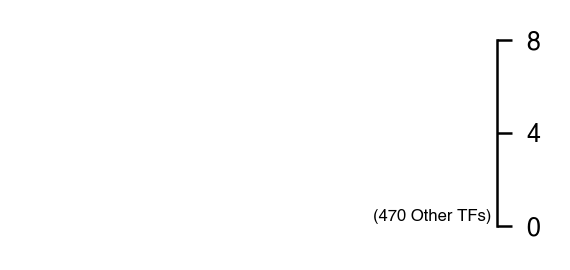

In [11]:
from matplotlib import patches
import numpy as np

label_y_cutoff = 7

df = tf_sum_rs[tf_sum_rs > label_y_cutoff]
other_count = tf_sum_rs[tf_sum_rs <= label_y_cutoff].size
df[f'({other_count} Other TFs)'] = 0.2

# c=[groupColors.get(langnameGroup[label],'k') for label in df.index]
fig = plt.figure(figsize=(2, 1), dpi=300)
gs = fig.add_gridspec(1, 10)

ax = fig.add_subplot(gs[0, :])
# ax_scatter = fig.add_subplot(gs[0, 9:])

ax.axes.get_xaxis().set_visible(False)
ax.set_xlim(-40, 0.1)
ax.set_ylim(0, 8)
ax.set_yticks([0, 4, 8])

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_label_position('right')
ax.yaxis.set_ticks_position('right')

plt.tight_layout()

patch = patches.Rectangle((-0.1, 0), 0.2, 100, fill=False, alpha=0)
# We add a rectangle to make sure the labels don't move to the right
ax.add_patch(patch)

texts = []
np.random.seed(0)
for label, y in zip(df.index, df):
    texts += [
        ax.text(
            -.1 + np.random.random() / 1000,
            y + np.random.random() / 1000,
            label,
            # A small random shift prevents labels
            # which have exactly the same coordinates from being stuck together
            # (not a problem in this example really, but wanted to mention this possibility)
            color='k',
            fontsize=4)
    ]
adjust_text(
    texts,
    [0 for _ in df],
    df,
    ha='left',
    va='center',
    add_objects=[patch],
    expand_text=(1.05, 1),
    # We want them to be quite compact, so reducing expansion makes sense
    force_text=(0.75, 0),
    force_objects=(1, 0),
    #With default forces it takes a very long time to converge,
    # but higher values still produce very nice output
    autoalign=False,
    only_move={
        'points': 'x',
        'text': 'x',
        'objects': 'x'
    })

fig.savefig('Inh.Motif.total_rs.strip_plot.text_part.pdf', bbox_inches='tight')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/seaborn/utils.py:238: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.get_visible instead.
  maj_on = any(t.tick1On for t in ax_i.yaxis.majorTicks)
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/seaborn/utils.py:239: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.get_visible instead.
  min_on = any(t.tick1On for t in ax_i.yaxis.minorTicks)
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/seaborn/utils.py:242: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = maj_on
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/seaborn/utils.py:244: MatplotlibDeprecationWarning: 
The tick2On fun

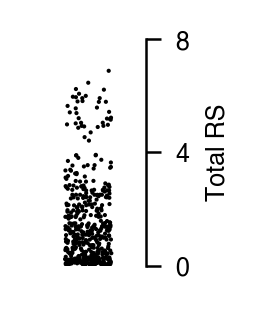

In [12]:
fig, ax = plt.subplots(figsize=(0.5, 1), dpi=300)
sns.stripplot(y=tf_sum_rs, jitter=0.2, s=1, color='k')
sns.despine(ax=ax, bottom=True, left=True, right=False)
ax.set_ylabel('Total RS')
ax.yaxis.set_label_position('right')
ax.yaxis.set_ticks_position('right')
ax.set_ylim(0, 8)
ax.set_yticks([0, 4, 8])

ax.set_xticks([])

fig.savefig('Inh.Motif.total_rs.strip_plot.scatter_part.pdf')

In [16]:
from ALLCools.motif.utilities import *

pfm_dict = meme_to_pfm_dict(
    '/home/hanliu/ref/MEME/selected_motifs_sets/JASPAR2020_CORE_vertebrates_non-redundant_pfms.meme'
)

use_top = tf_sum_rs.groupby(motif_gene_anno['SubFamily']).median().sort_values(ascending=False)[:10]
use_top

SubFamily
MEF2            5.404551
Fos             5.171590
POU3            5.006414
POU1            4.931293
POU4            4.037961
NFE2            3.544948
POU2            3.480285
ASC             3.452994
Myogenic TFs    3.349667
PAX4-like       3.226606
Name: impact, dtype: float64

In [22]:
tf_sum_rs.size, tf_sum_rs.groupby(motif_gene_anno['SubFamily']).median().size

(470, 164)

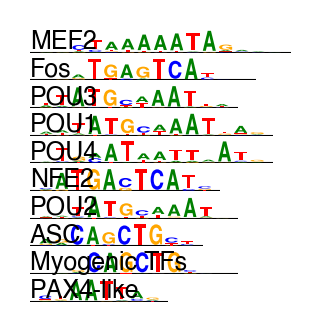

In [18]:
motifs = tf_sum_rs.groupby(motif_gene_anno['SubFamily']).idxmax().loc[use_top.index]
pfms = {k:pfm_dict[v] for k,v in motifs.items()}

max_col = max((i.shape[0] for i in pfms.values()))

fig = plt.figure(figsize=(1.5, 1.2), dpi=300)

gs = fig.add_gridspec(len(pfms), 20)

for i, (name, pfm) in enumerate(pfms.items()):
    ax = fig.add_subplot(gs[i, :pfm.shape[0]])
    plot_pfm(pfm=pfm, ax=ax)
    ax.axis('off')
    ax.text(0, 0.5, name, fontsize=6,
            ha='left', va='center', transform=ax.transAxes)
    
fig.savefig('Inh.Motif.top_logos.pdf')